# Создание телеграмм-бота, способного отправлять прогноз погоды

1. Для работы с ботом нужно открыть командную строку в меню пуск и прописать cmd

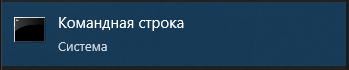

После чего нужно ввести команду для установки библиотеки:

*pip install python-telegram-bot*


2. Нужно зайти в телеграмм и поиске ввести BotFather

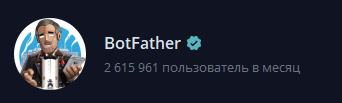

Вводим команду */newbot* после чего указываем название бота. В конце мы должны получить сообщение, в котором есть токен нашего созданного бота. Пример: *7722632322:AAHn7_icmtR6iBPngyl-o31kIM7gwwjGDC*

3. Переходим в среду разработки (VS code), создаем новый файл и вставляем шаблонный код для нашего бота


In [ ]:
from telegram import Update  
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters, ContextTypes                      # Импортируем необходимые классы из библиотеки python-telegram-bot

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):                                                    # Когда пользователь отправляет команду /start, вызывается эта функция
    await update.message.reply_text("Привет! Я бот.")                                                                   # Отправляем ответное сообщение пользователю


async def echo(update: Update, context: ContextTypes.DEFAULT_TYPE):                                                     # Когда пользователь отправляет текстовое сообщение (не команду), вызывается эта функция
    await update.message.reply_text("Привет")                                                                           # Отправляем ответное сообщение "Привет"

def main():                                                                                                             # Основная функция, которая запускает бота
   
    token = "7722632322:AAHn7_icmtR6iBPngyl-o31kIM7gwwjGDCs"                                                            # Вставьте сюда ваш токен

    application = ApplicationBuilder().token(token).build()                                                             # ApplicationBuilder используется для настройки и запуска бота
                                                                                                                        # Добавляем обработчики команд и сообщений
                                                                                                                        # CommandHandler — это обработчик команд (например, /start)
                                                                                                                        # Здесь мы связываем команду /start с функцией start
    application.add_handler(CommandHandler("start", start))
                                                                                                                        # MessageHandler — это обработчик текстовых сообщений
                                                                                                                        # filters.TEXT & ~filters.COMMAND означает, что обрабатываются только текстовые сообщения, не являющиеся командами
                                                                                                                        # Мы связываем этот обработчик с функцией echo
    application.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, echo))
                                                                                                                        # Запускаем бота в режиме polling
                                                                                                                        # Polling — это постоянный опрос серверов Telegram на предмет новых сообщений
    print("Бот запущен...")
    application.run_polling()

if __name__ == "__main__":                                                                                              # Проверяем, что скрипт запущен напрямую (а не импортирован как модуль)
    
    main()                                                                                                              # Вызываем основную функцию

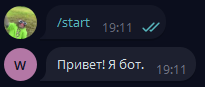

Как видим, все прекрасно работает. Теперь перейдем к решению нашей задачи. Прежде всего нужно настроить получение данных погоды с сайтов погоды. 

4. Нужно зайти на выбранный сайт погоды, в данном случае будет *openweathermap* и получить его API для дальнейших обращений

В данном случае он будет таким: *c3f4b5cf165df3b78ea314816f479762*

5. Теперь напишем код для обращения к сайту. Мы пишем город, в ответ получаем данные о погоде


In [ ]:
import requests                                                                                         # Для выполнения HTTP-запросов к API
from telegram import Update  
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters, ContextTypes
from googletrans import Translator
from langdetect import detect

                                                                        
async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):                                    # Функция для обработки команды /start
    await update.message.reply_text("Привет! Я бот погоды. Напишите название города, чтобы узнать погоду.")

async def get_weather(update: Update, context: ContextTypes.DEFAULT_TYPE):                              # Функция для обработки текстовых сообщений (название города)
    translator = Translator()
    
    city = update.message.text                                                                          # Получаем название города из сообщения пользователя
    src = detect(city)  
    result = await translator.translate(city, src=src, dest='en')                                       # Переводим название города на английский язык
    city_new = result.text
    
    api_token = "c3f4b5cf165df3b78ea314816f479762"  # Ваш токен для geometeo.ru
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city_new}&appid={api_token}"

    try:
        response = requests.get(url)                                                                    # Делаем запрос к API OpenWeatherMap
        data = response.json()

        if data["cod"] == 200:                                                                          # Если запрос успешен
            weather_description = data["weather"][0]["description"]                                     # Описание погоды
            temperature = data["main"]["temp"]                                                          # Температура в градусах Цельсия
            humidity = data["main"]["humidity"]                                                         # Влажность
            wind_speed = data["wind"]["speed"]                                                          # Скорость ветра
    
            result = await translator.translate(weather_description, src='en', dest='ru')               # Переводим данные с английского языка на русский
            weather_description_new = result.text
            
            message = (                                                                                 # Формируем ответное сообщение
                f"Погода в городе {city.capitalize()}:\n"
                f"Температура: {int(temperature-273.15)}°C\n"
                f"Описание: {weather_description_new}\n"
                f"Влажность: {humidity}%\n"
                f"Скорость ветра: {wind_speed} м/с"
            )
        else:
            message = "Город не найден. Попробуйте еще раз."                                            # Если город не найден или произошла ошибка

        await update.message.reply_text(message)                                                        # Отправляем ответ пользователю

    except Exception as e:
        await update.message.reply_text("Произошла ошибка. Попробуйте позже.")                          # Обработка ошибок (например, проблемы с подключением)

def main():                                                                                             # Основная функция для запуска бота
    
    token = "7722632322:AAHn7_icmtR6iBPngyl-o31kIM7gwwjGDCs"                                            # Вставьте сюда токен вашего Telegram-бота
    application = ApplicationBuilder().token(token).build()
    
    application.add_handler(CommandHandler("start", start))                                             # Обработчик команды /start
    application.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, get_weather))               # Обработчик текстовых сообщений

    
    print("Бот запущен...")                                                                             # Запускаем бота
    application.run_polling()

if __name__ == "__main__":
    main()

Мы смогли создать бота, который присылает данные о погоде в ответ на название города: Температура, влажность, скорость ветра, влажность. В целом, задачу можно считать выполненной, но можно улучшить нашего бота. Добавим команду, которая будет выводить будущую погоду для выбранного города в формате */forecast Москва*

In [ ]:
import requests                                                                                     # Для выполнения HTTP-запросов к API
from telegram import Update                                                                         # Класс, представляющий обновление от Telegram
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters, ContextTypes
from googletrans import Translator
from langdetect import detect
from datetime import datetime

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE):                                # Функция для обработки команды /start
    await update.message.reply_text("Привет! Я бот погоды. Напишите название города, чтобы узнать погоду.")

async def get_weather(update: Update, context: ContextTypes.DEFAULT_TYPE):                          # Функция для обработки текстовых сообщений (название города)
    translator = Translator()
    city = update.message.text                                                                      # Получаем название города из сообщения пользователя
    src = detect(city)  
    result = await translator.translate(city, src=src, dest='en')
    city_new = result.text
    
    api_token = "c3f4b5cf165df3b78ea314816f479762"                                                  # Ваш токен для geometeo.ru
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city_new}&appid={api_token}"

    try:
        response = requests.get(url)                                                                # Делаем запрос к API OpenWeatherMap
        data = response.json()

        if data["cod"] == 200:                                                                      # Если запрос успешен
            weather_description = data["weather"][0]["description"]                                 # Описание погоды
            temperature = data["main"]["temp"]                                                      # Температура в градусах Цельсия
            humidity = data["main"]["humidity"]                                                     # Влажность
            wind_speed = data["wind"]["speed"]                                                      # Скорость ветра
            
            result = await translator.translate(weather_description, src='en', dest='ru')
            weather_description_new = result.text
            
            timezone_offset = data["timezone"]                                                      # Смещение времени относительно UTC
            current_time_utc = datetime.utcnow()
            current_time_local = current_time_utc.timestamp() + timezone_offset
            local_time = datetime.fromtimestamp(current_time_local).strftime('%Y-%m-%d %H:%M:%S')
            
            message = (                                                                              # Формируем ответное сообщение
                f"Погода в городе {city.capitalize()}:\n"
                f"Текущее время: {local_time}\n"
                f"Температура: {int(temperature-273.15)}°C\n"
                f"Описание: {weather_description_new}\n"
                f"Влажность: {humidity}%\n"
                f"Скорость ветра: {wind_speed} м/с"
            )
        else:
            message = "Город не найден. Попробуйте еще раз."                                        # Если город не найден или произошла ошибка

        await update.message.reply_text(message)                                                    # Отправляем ответ пользователю

    except Exception as e:
        await update.message.reply_text("Произошла ошибка. Попробуйте позже.")
        
async def get_forecast(update: Update, context: ContextTypes.DEFAULT_TYPE):                         # функция прогнозирования будущей погоды
    
    if not context.args:
        await update.message.reply_text("Пожалуйста, укажите город после команды. Например: /forecast Москва")
        return

    city = " ".join(context.args).strip()                                                           # Объединяем все аргументы в одно название города

    try:
        translator = Translator()
        src = detect(city)  
        result = await translator.translate(city, src=src, dest='en')
        city_new = result.text
        api_token = "c3f4b5cf165df3b78ea314816f479762"
        url = f"http://api.openweathermap.org/data/2.5/forecast?q={city_new}&appid={api_token}&units=metric"

        response = requests.get(url)
        data = response.json()

        if data["cod"] == "200": 
            forecast_list = data["list"]
            forecast_2_hours = forecast_list[1]                                                     # Прогноз через 2-3 часа (второй элемент списка)

            weather_description = forecast_2_hours["weather"][0]["description"]
            temperature = forecast_2_hours["main"]["temp"]
            humidity = forecast_2_hours["main"]["humidity"]
            wind_speed = forecast_2_hours["wind"]["speed"]
                                                                                                    # Время прогноза
            forecast_time = datetime.fromtimestamp(forecast_2_hours["dt"]).strftime('%Y-%m-%d %H:%M:%S')    

            result = await translator.translate(weather_description, src='en', dest='ru')
            weather_description_new = result.text

            message = (
                f"Прогноз погоды в городе {city.capitalize()} на {forecast_time}:\n"
                f"Температура: {temperature}°C\n"
                f"Описание: {weather_description_new}\n"
                f"Влажность: {humidity}%\n"
                f"Скорость ветра: {wind_speed} м/с"
            )
        else:
            message = "Город не найден. Попробуйте еще раз."

        await update.message.reply_text(message)

    except Exception as e:
        await update.message.reply_text("Произошла ошибка. Попробуйте позже.")        

def main():
    token = "7722632322:AAHn7_icmtR6iBPngyl-o31kIM7gwwjGDCs"                                        # Вставьте сюда токен вашего Telegram-бота

    application = ApplicationBuilder().token(token).build()

    application.add_handler(CommandHandler("start", start))  # Обработчик команды /start
    application.add_handler(CommandHandler("forecast", get_forecast))  # Команда для прогноза погоды
    application.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, get_weather))  # Обработчик текстовых сообщений

    print("Бот запущен...")
    application.run_polling()

if __name__ == "__main__":
    main()
    

Итак, в ходе данного урока мы смогли разработать телеграмм бота который отправляет нам погоду. В будущем данного бота можно улучшить, расширить функционал и добавить различные команды, кнопки.